# Inception

In [1]:
import os.path
import re
import sys

import numpy as np
import tensorflow as tf

from IPython.display import Image

IMAGE_PATH='../../data/classifier/positives/p20160719233408_LINEDETECT-10.jpg'
MODEL__DIR = '../../model/inception3/'

## Load inception model

In [2]:
class NodeLookup(object):
    """Converts integer node ID's to human readable labels."""

    def __init__(self, label_lookup_path=None, uid_lookup_path=None):
        if not label_lookup_path:
            label_lookup_path = MODEL__DIR + 'imagenet_2012_challenge_label_map_proto.pbtxt'
        if not uid_lookup_path:
            uid_lookup_path = MODEL__DIR + 'imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        """Loads a human readable English name for each softmax node.

        Args:
          label_lookup_path: string UID to integer node ID.
          uid_lookup_path: string UID to human-readable string.

        Returns:
          dict from integer node ID to human-readable string.
        """
        if not tf.gfile.Exists(uid_lookup_path):
            tf.logging.fatal('File does not exist %s', uid_lookup_path)
        if not tf.gfile.Exists(label_lookup_path):
            tf.logging.fatal('File does not exist %s', label_lookup_path)

        # Loads mapping from string UID to human-readable string
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        p = re.compile(r'[n\d]*[ \S,]*')
        for line in proto_as_ascii_lines:
            parsed_items = p.findall(line)
            uid = parsed_items[0]
            human_string = parsed_items[2]
            uid_to_human[uid] = human_string

        # Loads mapping from string UID to integer node ID.
        node_id_to_uid = {}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]

        # Loads the final mapping of integer node ID to human-readable string
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: %s', val)
            name = uid_to_human[val]
            node_id_to_name[key] = name

        return node_id_to_name

    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

with tf.gfile.FastGFile('../../model/inception3/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

In [3]:
graph = tf.get_default_graph()
print('There are %d operations' % len(graph.get_operations()))
# print('Operation 0:')
# print(str(graph.get_operations()[0]))
# for op in graph.get_operations():
#     print(op.name)

There are 1004 operations


## Recognize image

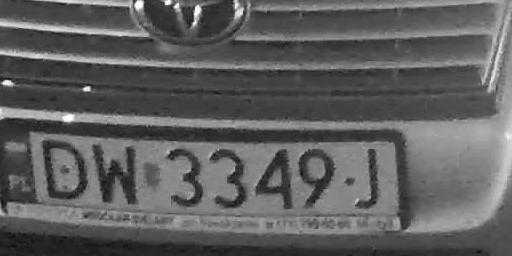

In [4]:
Image(filename=IMAGE_PATH)

In [5]:
image_data = tf.gfile.FastGFile(IMAGE_PATH, 'rb').read()
with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
    predictions = np.squeeze(predictions)

    # Creates node ID --> English string lookup.
    node_lookup = NodeLookup()

    top_k = predictions.argsort()[-5:][::-1]
    for node_id in top_k:
        human_string = node_lookup.id_to_string(node_id)
        score = predictions[node_id]
        print('%s (score = %.5f)' % (human_string, score))

pencil sharpener (score = 0.14535)
thimble (score = 0.11787)
grille, radiator grille (score = 0.06278)
lighter, light, igniter, ignitor (score = 0.03309)
coffee mug (score = 0.02456)


## Load next-to-last layer

In [6]:
image_data = tf.gfile.FastGFile(IMAGE_PATH, 'rb').read()
with tf.Session() as sess:
    pool_tensor = sess.graph.get_tensor_by_name('pool_3:0')
    predictions = sess.run(pool_tensor, {'DecodeJpeg/contents:0': image_data})
    print(predictions.size)

2048
